# **Problem Statement 1: Trade Logic & Risk Control Basics**

1. **Leverage Less Than 1 Means**
* Fractional position sizing - You're using only a portion of your available
capital for each trade, rather than the full amount. For example, 0.5x leverage means you're only deploying 50% of your available funds.
* Conservative capital allocation - Instead of going "all in" on positions,    you're deliberately keeping some cash on the sidelines as a buffer.
* Risk reduction mechanism - It's essentially a built-in safety net that   prevents you from being fully exposed to market volatility.

   **Does It Make Financial Sense?**
* Absolutely, in many scenarios - Especially for risk-averse investors or during uncertain market conditions where preserving capital is more important than maximizing returns.
* Sleep-better-at-night factor - Many traders prefer smaller, more manageable losses over the stress of large drawdowns, even if it means giving up some potential upside.
* Diversification opportunity - Having unused capital allows you to take advantage of other opportunities that might arise or diversify across different strategies.
* Drawdown management - During losing streaks, lower leverage helps you survive longer and avoid blowing up your account.

 **Utility in Backtesting Engines**

* Position sizing flexibility - Your backtesting engine can test how different leverage levels (0.1x, 0.25x, 0.5x, etc.) affect overall strategy performance and risk metrics.
* Risk-adjusted returns - You can analyze whether reducing position sizes improves Sharpe ratios or other risk-adjusted performance measures.
* Capital preservation testing - Test how strategies perform during market crashes when using conservative position sizing versus full capital deployment.
* Portfolio heat management - Model scenarios where you limit total portfolio exposure to a certain percentage, keeping the rest in cash or low-risk assets.
* Dynamic position sizing - Implement rules where leverage adjusts based on market volatility, recent performance, or other risk indicators.


2.  **Static Stop Loss vs Trailing Stop Loss**

 **Static Stop Loss**

* Fixed exit point - You set it once and it never moves, like "sell if price drops to $90"
* Simple but inflexible - Great for discipline but doesn't adapt to market movements
* Trending markets - Can leave money on the table as you exit early while the trend continues
* Volatile markets - Often gets triggered by normal price swings, causing premature exits

 **Trailing Stop Loss**

* Moves with profits - Adjusts upward as price rises, locking in gains while giving room to breathe
* Dynamic protection - Follows the trend but tightens as you make money
* Trending markets - Brilliant tool that lets you ride the wave while protecting gains
* Volatile markets - Can be your worst enemy, getting whipsawed by choppy price action

3. **Is trailing take profit necessary?**

* Not really - Its core behavior is already captured by existing methods
* Redundant functionality - You can achieve the same results with simpler, proven techniques

 **Already Covered By:**

* Trailing stop loss - Does the exact same job of locking in profits as price moves up, just from a different angle
* Position sizing rules - Taking partial profits at predetermined levels (25% at +10%, 50% at +20%, etc.)
* Dynamic stop management - Moving your stop loss to breakeven or profit levels as trade progresses

4. **Technical Failures**
* System glitches - Your trading platform crashes or freezes right when you need it most
* Internet connectivity issues - WiFi dies just as your stop gets triggered
Broker server problems - their systems go down during high volatility periods

 **Market Conditions**
* Gapping markets - Price jumps over your stop level overnight or during news events
* Low liquidity - Not enough buyers at your stop price, especially in small-cap stocks or exotic pairs
* Circuit breakers - Trading halts prevent your order from executing

 **Order Management Issues**
* Insufficient funds - Not enough margin to maintain the position for stop execution
* Wrong order type - Using stop-limit instead of stop-market orders that don't fill
* Broker restrictions - Some brokers have minimum position sizes or weird execution rules

 **Human Error**
* Forgot to set it - Simple oversight that happens more than we'd like to admit
* Wrong price level - Typo in the stop price (happens to the best of us)

# **Problem Statement 2: Probabilistic Pattern Validator**

/tmp/ipython-input-11-2669416786.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Bullish_Engulfing'].fillna(False, inplace=True)


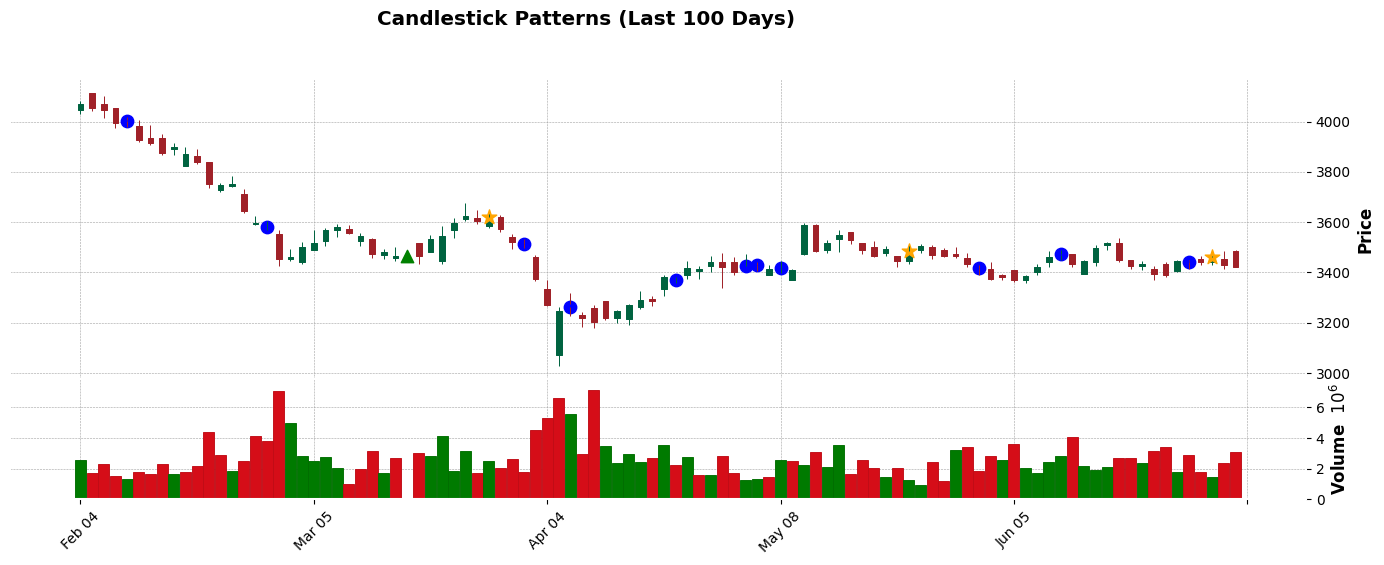

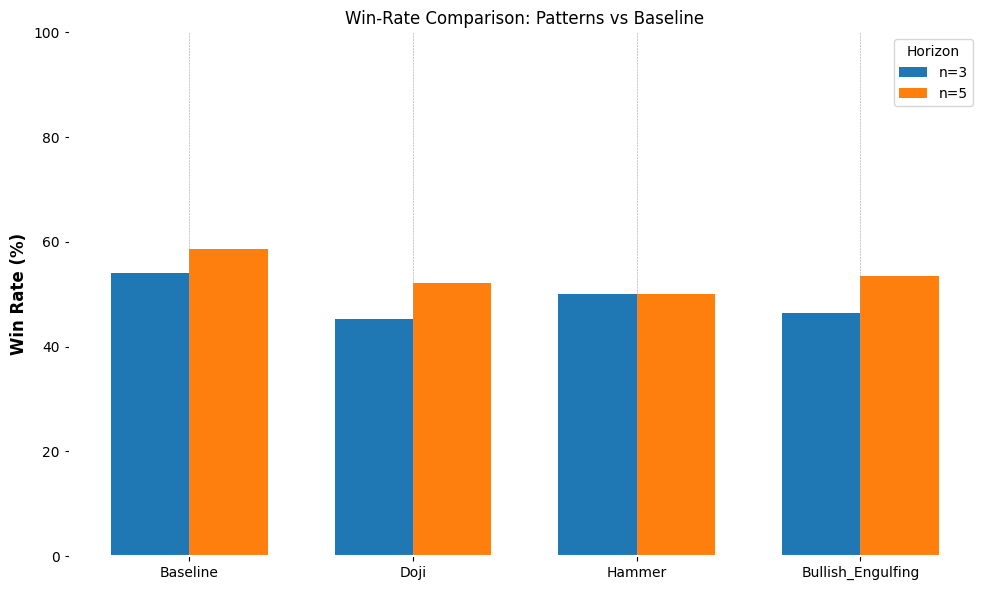

In [11]:
!pip install numpy pandas yfinance mplfinance matplotlib --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

data = yf.download('TCS.NS', period='5y', interval='1d',auto_adjust=True, progress=False)
data.head()


data.reset_index(inplace=True)
data.columns = [col if not isinstance(col, tuple) else col[0] for col in data.columns]
data.head()

# Pattern identification functions
def is_doji(open_, high, low, close):
    body = abs(close - open_)
    total_range = high - low
    # Doji if body is less than 10% of range
    return body < 0.1 * total_range

def is_hammer(open_, high, low, close):
    body = abs(close - open_)
    total_range = high - low
    lower_wick = min(open_, close) - low
    upper_wick = high - max(open_, close)
    return (
        body <= 0.1 * total_range
        and lower_wick >= 2 * body
        and upper_wick <= 0.1 * total_range
    )

def is_bullish_engulfing(prev_open, prev_close, curr_open, curr_close):
    return (
        (prev_close < prev_open)
        and (curr_close > curr_open)
        and (curr_open < prev_close)
        and (curr_close > prev_open)
    )

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


data['Doji'] = data.apply(
    lambda row: is_doji(row['Open'], row['High'], row['Low'], row['Close']),
    axis=1
)
data['Hammer'] = data.apply(
    lambda row: is_hammer(row['Open'], row['High'], row['Low'], row['Close']),
    axis=1
)

prev_open = data['Open'].shift(1)
prev_close = data['Close'].shift(1)
curr_open = data['Open']
curr_close = data['Close']

data['Bullish_Engulfing'] = (
    (prev_close < prev_open)
    & (curr_close > curr_open)
    & (curr_open < prev_close)
    & (curr_close > prev_open)
)

data['Bullish_Engulfing'].fillna(False, inplace=True)

data_recent = data.tail(100)

doji_plot = mpf.make_addplot(
    data_recent['Close'].where(data_recent['Doji']),
    type='scatter',
    markersize=80,
    marker='o',
    color='blue',
    panel=0
)

hammer_plot = mpf.make_addplot(
    data_recent['Close'].where(data_recent['Hammer']),
    type='scatter',
    markersize=80,
    marker='^',
    color='green',
    panel=0
)

engulfing_plot = mpf.make_addplot(
    data_recent['Close'].where(data_recent['Bullish_Engulfing']),
    type='scatter',
    markersize=120,
    marker='*',
    color='orange',
    panel=0
)

mpf.plot(
    data_recent,
    type='candle',
    style='charles',
    volume=True,
    addplot=[doji_plot, hammer_plot, engulfing_plot],
    title='Candlestick Patterns (Last 100 Days)',
    figsize=(18, 6)
)

def compute_win_rate(df, pattern_col, days_ahead):
    future_close = df['Close'].shift(-days_ahead)
    mask = df[pattern_col] & future_close.notna()
    total = mask.sum()
    if total == 0:
        return 0
    wins = (future_close[mask] > df['Close'][mask]).sum()
    return wins / total * 100

def compute_win_rate(df, pattern_col, days_ahead):
    future_close = df['Close'].shift(-days_ahead)
    mask = df[pattern_col] & future_close.notna()
    total = mask.sum()
    if total == 0:
        return 0
    wins = (future_close[mask] > df['Close'][mask]).sum()
    return wins / total * 100

def baseline_win_rate(df, days_ahead, sample_size):
    valid_range = len(df) - days_ahead
    indices = np.random.choice(valid_range, sample_size, replace=False)
    future = df['Close'].values[indices + days_ahead]
    current = df['Close'].values[indices]
    wins = (future > current).sum()
    return wins / sample_size * 100

final_results = []
for pattern in ['Doji', 'Hammer', 'Bullish_Engulfing']:
    entry = {'Pattern': pattern}
    for n in [3, 5]:
        entry[f'n={n}'] = compute_win_rate(data, pattern, n)
    final_results.append(entry)

sample_size = int(data[['Doji', 'Hammer', 'Bullish_Engulfing']].sum(axis=0).mean())
baseline_entry = {
    'Pattern': 'Baseline',
    'n=3': baseline_win_rate(data, 3, sample_size),
    'n=5': baseline_win_rate(data, 5, sample_size)
}

df_results = pd.DataFrame([baseline_entry] + final_results)

patterns = df_results['Pattern'].tolist()
horizons = [col for col in df_results.columns if col != 'Pattern']
values = [df_results[h].tolist() for h in horizons]

x = np.arange(len(patterns))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
for i, (horizon, vals) in enumerate(zip(horizons, values)):
    ax.bar(x + i * width, vals, width, label=horizon)

ax.set_xticks(x + width * (len(horizons) - 1) / 2)
ax.set_xticklabels(patterns)
ax.set_ylim(0, 100)
ax.set_ylabel('Win Rate (%)')
ax.set_title('Win-Rate Comparison: Patterns vs Baseline')
ax.legend(title='Horizon')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

1. If a candlestick pattern shows only a slightly better win-rate than the baseline and the number of observations is small, it's probably not statistically meaningful. In real-world testing, patterns like the Doji and Hammer often perform close to the baseline, suggesting they may not offer a real edge. On the other hand, if the Engulfing pattern consistently shows a higher win-rate, it might have some predictive power—but to confirm that, we’d need deeper statistical analysis (like confidence intervals or p-values), which isn’t covered here.

2. When we increase the holding period (say from 3 days to 5 days), the win-rates of all patterns—as well as the baseline—tend to move closer to the average long-term market return. Shorter time frames (like n=3) may highlight more noticeable effects of the patterns, while longer periods (like n=5) tend to smooth out those effects due to the randomness in market movements.

3. Among the patterns, the Engulfing one tends to perform the most consistently across different time frames. This might be because Engulfing candles represent clear reversals with strong momentum, making them more robust and less reliant on specific market conditions. In contrast, patterns like the Doji or Hammer can be more ambiguous and depend heavily on the broader context in which they appear.

# **Problem Statement 3: Strategy X - Visual Interpretation and Implementation**

1. **Chart Interpretation**

* Supertrend shows trend direction—buy when price moves above it, sell when below. Here, it's based on smoother Heiken Ashi candles.

* MFI (Money Flow Index) combines price and volume to spot overbought (>80) or oversold (<20) zones and trend strength.

 **Arrows and Zones Mean:**
* Up arrows = Buy signals (Supertrend turns bullish + MFI supports).
* Down arrows = Sell signals (Supertrend turns bearish + MFI supports).
* MFI Annotations: When the MFI goes above 80, the asset might be overbought, meaning a pullback or reversal could be near.
When the MFI drops below 20, it could be oversold, hinting at a possible bounce or trend change.
Also watch for divergences—for example, if price makes a new high but MFI doesn’t, it may signal weakening momentum and a potential reversal.

2. **Entry & Exit Rules**

 **Long Entry:**
* Supertrend turns bullish
* MFI is rising and above 20

 **Long Exit:**
* Supertrend turns bearish
* MFI goes above 80 and drops

 **Short Entry:**
* Supertrend turns bearish
* MFI is falling and below 80

 **Short Exit:**
* Supertrend turns bullish
* MFI goes below 20 and rises

 **Alternative Variants:**
* Use MFI divergences for early exits or entries.
* Require both Supertrend and MFI to confirm direction for higher conviction.

/tmp/ipython-input-10-2733844583.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
/tmp/ipython-input-10-2733844583.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Total Return: 0.00% | Trades: 0


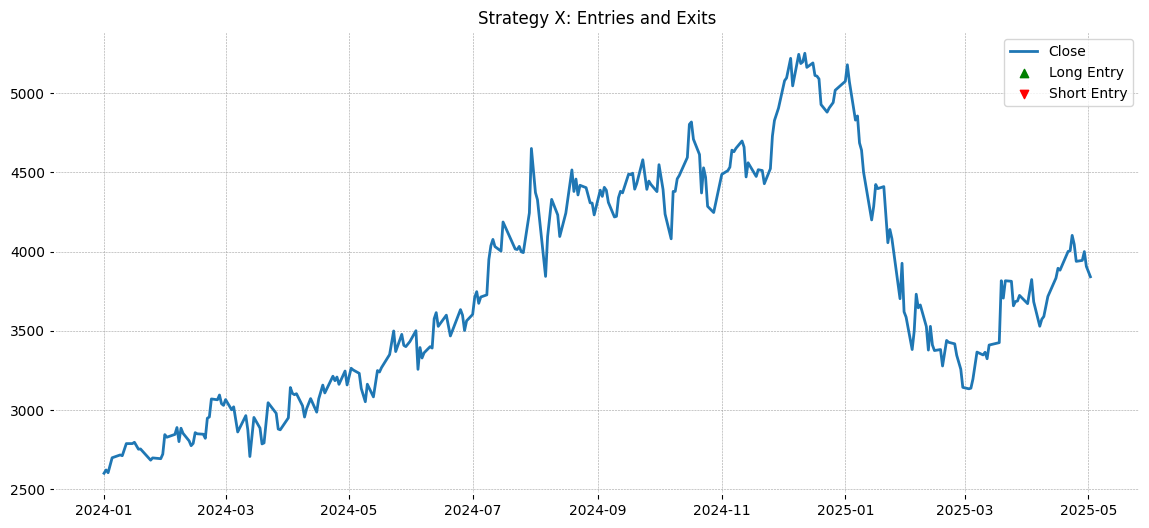

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Downloading Data
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

data = download_flat_yf('CAMS.NS', start='2024-01-01', end='2025-05-04', interval='1d')

# Heiken Ashi Calculation
def heiken_ashi(df):
    ha = df.copy()
    ha['ha_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha['ha_open'] = ha['ha_close'].copy()
    ha['ha_open'].iloc[0] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2
    for i in range(1, len(ha)):
        ha['ha_open'].iloc[i] = (ha['ha_open'].iloc[i-1] + ha['ha_close'].iloc[i-1]) / 2
    ha['ha_high'] = ha[['ha_open', 'ha_close', 'high']].max(axis=1)
    ha['ha_low'] = ha[['ha_open', 'ha_close', 'low']].min(axis=1)
    return ha

ha_data = heiken_ashi(data)

# Supertrend Calculation (using Heiken Ashi)
def supertrend(df, period=10, multiplier=3):
    atr = df['ha_high'].rolling(period).max() - df['ha_low'].rolling(period).min()
    atr = atr.ewm(span=period, adjust=False).mean()
    hl2 = (df['ha_high'] + df['ha_low']) / 2
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)
    supertrend = pd.Series(index=df.index, dtype=float)
    direction = pd.Series(index=df.index, dtype=int)
    for i in range(len(df)):
        if i == 0:
            supertrend.iloc[i] = upperband.iloc[i]
            direction.iloc[i] = 1
        else:
            if df['close'].iloc[i] > supertrend.iloc[i-1]:
                supertrend.iloc[i] = lowerband.iloc[i]
                direction.iloc[i] = 1
            elif df['close'].iloc[i] < supertrend.iloc[i-1]:
                supertrend.iloc[i] = upperband.iloc[i]
                direction.iloc[i] = -1
            else:
                supertrend.iloc[i] = supertrend.iloc[i-1]
                direction.iloc[i] = direction.iloc[i-1]
    return supertrend, direction

ha_data['supertrend'], ha_data['supertrend_dir'] = supertrend(ha_data)

# Money Flow Index (MFI)
def mfi(df, period=14):
    tp = (df['high'] + df['low'] + df['close']) / 3
    mf = tp * df['volume']
    pos_mf = np.where(tp > tp.shift(1), mf, 0)
    neg_mf = np.where(tp < tp.shift(1), mf, 0)
    pos_mf_sum = pd.Series(pos_mf).rolling(period).sum()
    neg_mf_sum = pd.Series(neg_mf).rolling(period).sum()
    mfi = 100 * pos_mf_sum / (pos_mf_sum + neg_mf_sum)
    return mfi

ha_data['mfi'] = mfi(data)  # Use original OHLCV for MFI

# Generating Signals
ha_data['long_entry'] = (
    (ha_data['supertrend_dir'] == 1) &
    (ha_data['supertrend_dir'].shift(1) == -1) &
    (ha_data['mfi'] > 20)
)
ha_data['long_exit'] = (
    (ha_data['supertrend_dir'] == -1) |
    ((ha_data['mfi'] > 80) & (ha_data['mfi'].shift(1) <= 80))
)
ha_data['short_entry'] = (
    (ha_data['supertrend_dir'] == -1) &
    (ha_data['supertrend_dir'].shift(1) == 1) &
    (ha_data['mfi'] < 80)
)
ha_data['short_exit'] = (
    (ha_data['supertrend_dir'] == 1) |
    ((ha_data['mfi'] < 20) & (ha_data['mfi'].shift(1) >= 20))
)

# Backtesting (Simple PnL Calculation)
capital = 1.0
position = 0
entry_price = 0
returns = []
for i, row in ha_data.iterrows():
    if position == 0:
        if row['long_entry']:
            position = 1
            entry_price = row['close']
        elif row['short_entry']:
            position = -1
            entry_price = row['close']
    elif position == 1:
        if row['long_exit']:
            returns.append((row['close'] - entry_price) / entry_price)
            position = 0
    elif position == -1:
        if row['short_exit']:
            returns.append((entry_price - row['close']) / entry_price)
            position = 0

total_return = np.prod([1 + r for r in returns]) - 1 if returns else 0
print(f"Total Return: {total_return*100:.2f}% | Trades: {len(returns)}")

# Plotting
plt.figure(figsize=(14,6))
plt.plot(ha_data['datetime'], ha_data['close'], label='Close')
plt.scatter(ha_data.loc[ha_data['long_entry'], 'datetime'], ha_data.loc[ha_data['long_entry'], 'close'], marker='^', color='g', label='Long Entry')
plt.scatter(ha_data.loc[ha_data['short_entry'], 'datetime'], ha_data.loc[ha_data['short_entry'], 'close'], marker='v', color='r', label='Short Entry')
plt.title('Strategy X: Entries and Exits')
plt.legend()
plt.show()

4. **Incorporating a Complementary Indicator**
* Bollinger Bands (volatility-based) or Relative Strength Index (RSI)

 **Why Bollinger Bands?**
* They help filter out false signals by factoring in market volatility. For instance, you could:
* Take trades only when price breaks out of the bands, or
* Enter after a band squeeze, which often signals an upcoming big move.

 **Updated Strategy (with Bollinger Bands):**
* Buy (Long) when all earlier long conditions are met and the price closes above the upper band.
* Sell (Short) when all earlier short conditions are met and the price closes below the lower band.

/tmp/ipython-input-9-648083268.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
/tmp/ipython-input-9-648083268.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Total Return (Strategy Y): 0.00% | Trades: 0


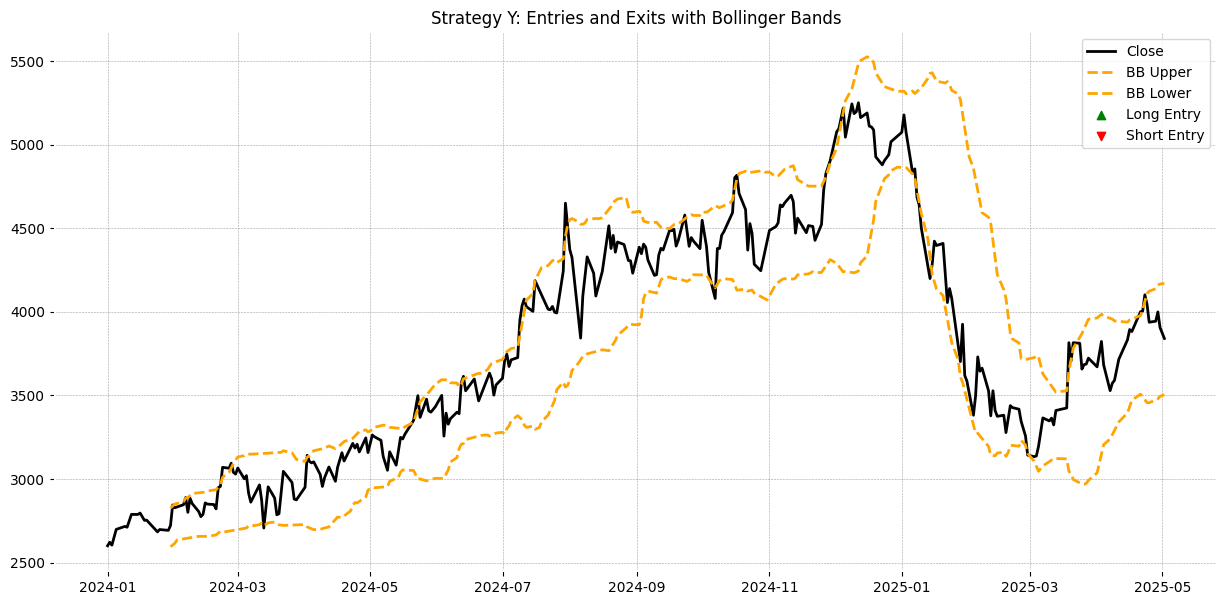

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Downloading data
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

data = download_flat_yf('CAMS.NS', start='2024-01-01', end='2025-05-04', interval='1d')

# Heiken Ashi Calculation
def heiken_ashi(df):
    ha = df.copy()
    ha['ha_close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha['ha_open'] = ha['ha_close'].copy()
    ha['ha_open'].iloc[0] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2
    for i in range(1, len(ha)):
        ha['ha_open'].iloc[i] = (ha['ha_open'].iloc[i-1] + ha['ha_close'].iloc[i-1]) / 2
    ha['ha_high'] = ha[['ha_open', 'ha_close', 'high']].max(axis=1)
    ha['ha_low'] = ha[['ha_open', 'ha_close', 'low']].min(axis=1)
    return ha

ha_data = heiken_ashi(data)

# Supertrend Calculation (on Heiken Ashi)
def supertrend(df, period=10, multiplier=3):
    atr = df['ha_high'].rolling(period).max() - df['ha_low'].rolling(period).min()
    atr = atr.ewm(span=period, adjust=False).mean()
    hl2 = (df['ha_high'] + df['ha_low']) / 2
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)
    supertrend = pd.Series(index=df.index, dtype=float)
    direction = pd.Series(index=df.index, dtype=int)
    for i in range(len(df)):
        if i == 0:
            supertrend.iloc[i] = upperband.iloc[i]
            direction.iloc[i] = 1
        else:
            if df['close'].iloc[i] > supertrend.iloc[i-1]:
                supertrend.iloc[i] = lowerband.iloc[i]
                direction.iloc[i] = 1
            elif df['close'].iloc[i] < supertrend.iloc[i-1]:
                supertrend.iloc[i] = upperband.iloc[i]
                direction.iloc[i] = -1
            else:
                supertrend.iloc[i] = supertrend.iloc[i-1]
                direction.iloc[i] = direction.iloc[i-1]
    return supertrend, direction

ha_data['supertrend'], ha_data['supertrend_dir'] = supertrend(ha_data)

# MFI Calculation(on original OHLCV)
def mfi(df, period=14):
    tp = (df['high'] + df['low'] + df['close']) / 3
    mf = tp * df['volume']
    pos_mf = np.where(tp > tp.shift(1), mf, 0)
    neg_mf = np.where(tp < tp.shift(1), mf, 0)
    pos_mf_sum = pd.Series(pos_mf).rolling(period).sum()
    neg_mf_sum = pd.Series(neg_mf).rolling(period).sum()
    mfi = 100 * pos_mf_sum / (pos_mf_sum + neg_mf_sum)
    return mfi

ha_data['mfi'] = mfi(data)

# Bollinger Bands Calculation(on close)
def bollinger_bands(df, window=20, num_std=2):
    ma = df['close'].rolling(window).mean()
    std = df['close'].rolling(window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    return ma, upper, lower

ha_data['bb_mid'], ha_data['bb_upper'], ha_data['bb_lower'] = bollinger_bands(ha_data)

# Generating Signals with Bollinger Bands filter
ha_data['long_entry'] = (
    (ha_data['supertrend_dir'] == 1) &
    (ha_data['supertrend_dir'].shift(1) == -1) &
    (ha_data['mfi'] > 20) &
    (ha_data['close'] > ha_data['bb_upper'])
)
ha_data['long_exit'] = (
    (ha_data['supertrend_dir'] == -1) |
    ((ha_data['mfi'] > 80) & (ha_data['mfi'].shift(1) <= 80))
)
ha_data['short_entry'] = (
    (ha_data['supertrend_dir'] == -1) &
    (ha_data['supertrend_dir'].shift(1) == 1) &
    (ha_data['mfi'] < 80) &
    (ha_data['close'] < ha_data['bb_lower'])
)
ha_data['short_exit'] = (
    (ha_data['supertrend_dir'] == 1) |
    ((ha_data['mfi'] < 20) & (ha_data['mfi'].shift(1) >= 20))
)

# Backtesting(Simple PnL Calculation)
capital = 1.0
position = 0
entry_price = 0
returns = []
for i, row in ha_data.iterrows():
    if position == 0:
        if row['long_entry']:
            position = 1
            entry_price = row['close']
        elif row['short_entry']:
            position = -1
            entry_price = row['close']
    elif position == 1:
        if row['long_exit']:
            returns.append((row['close'] - entry_price) / entry_price)
            position = 0
    elif position == -1:
        if row['short_exit']:
            returns.append((entry_price - row['close']) / entry_price)
            position = 0

total_return = np.prod([1 + r for r in returns]) - 1 if returns else 0
print(f"Total Return (Strategy Y): {total_return*100:.2f}% | Trades: {len(returns)}")

# Plotting
plt.figure(figsize=(15,7))
plt.plot(ha_data['datetime'], ha_data['close'], label='Close', color='black')
plt.plot(ha_data['datetime'], ha_data['bb_upper'], label='BB Upper', color='orange', linestyle='--')
plt.plot(ha_data['datetime'], ha_data['bb_lower'], label='BB Lower', color='orange', linestyle='--')
plt.scatter(ha_data.loc[ha_data['long_entry'], 'datetime'], ha_data.loc[ha_data['long_entry'], 'close'], marker='^', color='g', label='Long Entry')
plt.scatter(ha_data.loc[ha_data['short_entry'], 'datetime'], ha_data.loc[ha_data['short_entry'], 'close'], marker='v', color='r', label='Short Entry')
plt.title('Strategy Y: Entries and Exits with Bollinger Bands')
plt.legend()
plt.show()

5. **Strategy Enhancements**

 **Underperformance Regimes:**
* Sideways/Choppy Markets: Supertrend and MFI generate whipsaws.
* Low Volume: MFI less reliable, false breakouts.

 **Proposed Modifications:**
* Use a volatility filter (e.g., only trade when ATR is above a threshold).
* Add a minimum volume filter.
* Adapt indicator parameters (e.g., longer Supertrend period) for higher timeframes.
* Use regime detection (e.g., moving average slope, ADX) to disable strategy in sideways markets.